In [1]:
import numpy as np
import pandas as pd
import os
import h5py
import wandb

import string
import random

import torch 
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

import lightning as L
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import ModelCheckpoint


from torch import optim, utils, Tensor

import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
import sklearn.linear_model


from itables import show

Here, we had 3 different ways to evaluate when to stop based on validation performance (loss, f1, and error). We will look at the ROC curves between training and testing, and probably go with the one that shows the smallest difference in performance (not necessarily the best validation performance on its own). 

In [2]:


import os
os.environ['HTTP_PROXY']="http://www-int.dkfz-heidelberg.de:80"
os.environ['HTTPS_PROXY']="http://www-int.dkfz-heidelberg.de:80"


In [3]:

slide_meta = pd.read_csv("../metadata/labels_with_new_batch.csv")
ct_scoring = pd.read_csv("../metadata/CT_3_Class_Draft.csv")

ct_scoring["txt_idat"] = ct_scoring["idat"].astype("str")
ct_scoring.index = ct_scoring.txt_idat
slide_meta.index = slide_meta.idat
ct_scoring = ct_scoring.drop("txt_idat", axis=1)
slide_meta = slide_meta.drop("idat", axis=1)
slide_annots = slide_meta.join(ct_scoring, lsuffix="l")


slide_annots['file'] = slide_annots.uuid + ".h5"

slide_annots.index = slide_annots.uuid

In [4]:
slide_annots['labels'] = np.abs(1-slide_annots.CT_class.factorize(sort=True)[0])

In [5]:

api = wandb.Api()


In [6]:
runs = api.runs(path="psmirnov/UKHD_RetCLL_299_CT", filters={"group": "1HB2LR"})

# Loss

First we try using the loss, which I think is the least likely to work well. 

In [7]:
train_preds = list()
train_labels = list()
train_probs = list()

valid_preds = list()
valid_labels = list()
valid_probs = list()

test_preds = list()
test_labels = list()
test_probs = list()

train_mean = list()
valid_mean = list()
test_mean = list()
    
train_combined = list()
valid_combined = list()
test_combined = list()


In [8]:
for ii in range(len(runs)):
    arts = runs[ii].logged_artifacts()
    arts_dict = {a.name.removesuffix(':'+a.version): a for a in arts}
    training_slides = arts_dict['fold'].get('training').get_dataframe()
    valid_slides = arts_dict['fold'].get('validation').get_dataframe()
    testing_slides = arts_dict['fold'].get('testing').get_dataframe()
    
    train_data = slide_annots.loc[training_slides[0]]
    valid_data = slide_annots.loc[valid_slides[0]]
    test_data = slide_annots.loc[testing_slides[0]]
    
    train_mean.append(pd.merge(train_data,train_data.groupby('family').labels.mean(), how='left', left_on='family',right_on='family').labels_y)
    valid_mean.append(pd.merge(valid_data,train_data.groupby('family').labels.mean(), how='left', left_on='family',right_on='family').labels_y)
    test_mean.append(pd.merge(test_data,train_data.groupby('family').labels.mean(), how='left', left_on='family',right_on='family').labels_y)
    
    train_labels.append(np.abs(1-train_data.CT_class.factorize(sort=True)[0]))
    train_preds.append(arts_dict['preds_loss'].get('training').get_dataframe())
    train_probs.append(arts_dict['preds_loss'].get('training_probs').get_dataframe())

    valid_labels.append(np.abs(1-valid_data.CT_class.factorize(sort=True)[0]))
    valid_preds.append(arts_dict['preds_loss'].get('validation').get_dataframe())
    valid_probs.append(arts_dict['preds_loss'].get('validation_probs').get_dataframe())
    
    test_labels.append(np.abs(1-test_data.CT_class.factorize(sort=True)[0]))
    test_preds.append(arts_dict['preds_loss'].get('testing').get_dataframe())
    test_probs.append(arts_dict['preds_loss'].get('testing_probs').get_dataframe())
    
    logistic_model= sklearn.linear_model.LogisticRegression(penalty=None)

    X_train = np.stack([np.transpose(train_probs[ii][0]), np.array(train_mean[ii]).transpose()])
    X_valid = np.stack([np.transpose(valid_probs[ii][0]), np.array(valid_mean[ii]).transpose()])
    X_test = np.stack([np.transpose(test_probs[ii][0]), np.array(test_mean[ii]).transpose()])
     
    
    logistic_model.fit(X_train.transpose()[~np.isnan(train_mean[ii])], train_labels[ii][~np.isnan(train_mean[ii])])
    train_combined.append(logistic_model.predict_proba(X_train.transpose()[~np.isnan(train_mean[ii])]))
    valid_combined.append(logistic_model.predict_proba(X_valid.transpose()[~np.isnan(valid_mean[ii])]))
    test_combined.append(logistic_model.predict_proba(X_test.transpose()[~np.isnan(test_mean[ii])]))


wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   3 of 3 files downlo

In [9]:
train_mean = np.concatenate(train_mean)
valid_mean = np.concatenate(valid_mean)
test_mean = np.concatenate(test_mean)


In [10]:
train_combined = np.concatenate(train_combined)
valid_combined = np.concatenate(valid_combined)
test_combined = np.concatenate(test_combined)

In [11]:
len(np.concatenate(valid_preds))

1515

In [12]:
len(np.concatenate(test_preds))

1503

In [13]:
train_labels = np.concatenate(train_labels)
train_preds = np.concatenate(train_preds)
train_probs = np.concatenate(train_probs)


In [14]:
train_combined

array([[0.806336  , 0.193664  ],
       [0.89984144, 0.10015856],
       [0.99855134, 0.00144866],
       ...,
       [0.43542638, 0.56457362],
       [0.97080017, 0.02919983],
       [0.17658375, 0.82341625]])

## Train

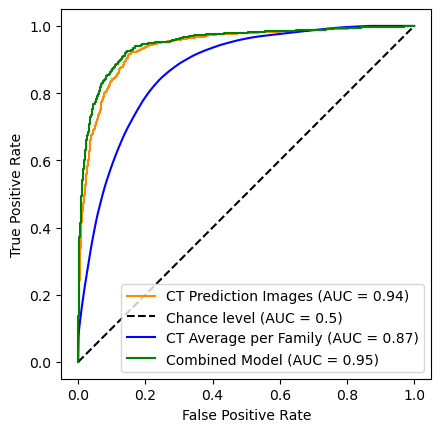

In [15]:
fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(
    train_labels,
    train_probs,
    name="CT Prediction Images",
    color="darkorange",
    plot_chance_level=True,
    ax=ax
)
RocCurveDisplay.from_predictions(
    train_labels[~np.isnan(train_mean)],
    train_mean[~np.isnan(train_mean)],
    name="CT Average per Family",
    color="blue",
    ax=ax,
)
RocCurveDisplay.from_predictions(
    train_labels[~np.isnan(train_mean)],
    # np.ones(preds_logistic.shape[0]),
    train_combined[:,1],
    # np.maximum( np.array(valid_data.labels).transpose(),np.transpose(valid_probs)),
    name="Combined Model",
    color="green",
    ax=ax
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("")
plt.legend()
plt.show()

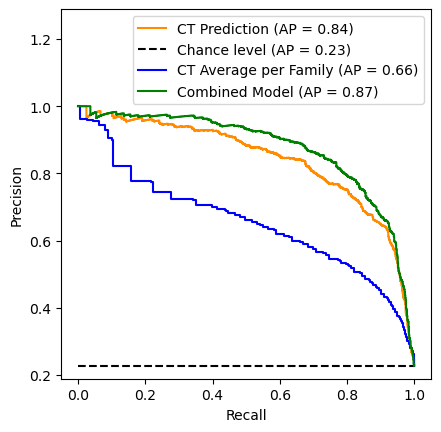

In [16]:
fig, ax = plt.subplots()
PrecisionRecallDisplay.from_predictions(
    train_labels,
    train_probs,
    name="CT Prediction",
    color="darkorange",
    plot_chance_level=True,
    ax=ax
)
PrecisionRecallDisplay.from_predictions(
    train_labels[~np.isnan(train_mean)],
    train_mean[~np.isnan(train_mean)],
    name="CT Average per Family",
    color="blue",
    ax=ax
)

PrecisionRecallDisplay.from_predictions(
    train_labels[~np.isnan(train_mean)],
    # np.ones(preds_logistic.shape[0]),
    train_combined[:,1],
    # np.maximum( np.array(valid_data.labels).transpose(),np.transpose(valid_probs)),
    name="Combined Model",
    color="green",
    ax=ax
)

plt.axis("square")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("")
plt.legend()
plt.show()

## Valid

In [17]:
valid_labels = np.concatenate(valid_labels)
valid_preds = np.concatenate(valid_preds)
valid_probs = np.concatenate(valid_probs)

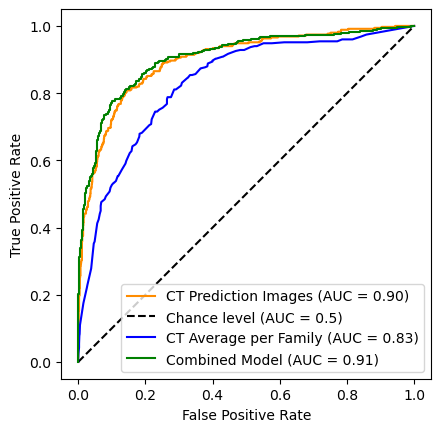

In [18]:
fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(
    valid_labels,
    valid_probs,
    name="CT Prediction Images",
    color="darkorange",
    plot_chance_level=True,
    ax=ax
)
RocCurveDisplay.from_predictions(
    valid_labels[~np.isnan(valid_mean)],
    valid_mean[~np.isnan(valid_mean)],
    name="CT Average per Family",
    color="blue",
    ax=ax,
)
RocCurveDisplay.from_predictions(
    valid_labels[~np.isnan(valid_mean)],
    # np.ones(preds_logistic.shape[0]),
    valid_combined[:,1],
    # np.maximum( np.array(valid_data.labels).transpose(),np.transpose(valid_probs)),
    name="Combined Model",
    color="green",
    ax=ax
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("")
plt.legend()
plt.show()

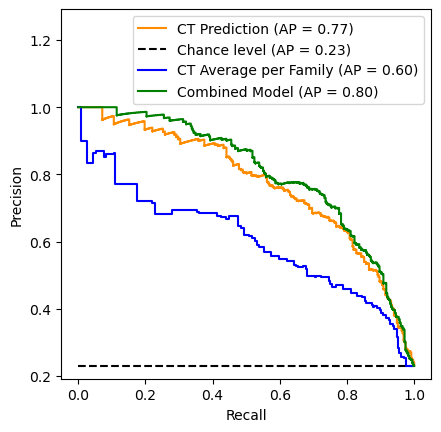

In [19]:
fig, ax = plt.subplots()
PrecisionRecallDisplay.from_predictions(
    valid_labels,
    valid_probs,
    name="CT Prediction",
    color="darkorange",
    plot_chance_level=True,
    ax=ax
)
PrecisionRecallDisplay.from_predictions(
    valid_labels[~np.isnan(valid_mean)],
    valid_mean[~np.isnan(valid_mean)],
    name="CT Average per Family",
    color="blue",
    ax=ax
)

PrecisionRecallDisplay.from_predictions(
    valid_labels[~np.isnan(valid_mean)],
    # np.ones(preds_logistic.shape[0]),
    valid_combined[:,1],
    # np.maximum( np.array(valid_data.labels).transpose(),np.transpose(valid_probs)),
    name="Combined Model",
    color="green",
    ax=ax
)

plt.axis("square")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("")
plt.legend()
plt.show()

# Error

Now, we try the error as the measure for selecting the model

In [20]:
train_preds = list()
train_labels = list()
train_probs = list()

valid_preds = list()
valid_labels = list()
valid_probs = list()

test_preds = list()
test_labels = list()
test_probs = list()

train_mean = list()
valid_mean = list()
test_mean = list()
    
train_combined = list()
valid_combined = list()
test_combined = list()


In [21]:
for ii in range(len(runs)):
    arts = runs[ii].logged_artifacts()
    arts_dict = {a.name.removesuffix(':'+a.version): a for a in arts}
    training_slides = arts_dict['fold'].get('training').get_dataframe()
    valid_slides = arts_dict['fold'].get('validation').get_dataframe()
    testing_slides = arts_dict['fold'].get('testing').get_dataframe()
    
    train_data = slide_annots.loc[training_slides[0]]
    valid_data = slide_annots.loc[valid_slides[0]]
    test_data = slide_annots.loc[testing_slides[0]]
    
    train_mean.append(pd.merge(train_data,train_data.groupby('family').labels.mean(), how='left', left_on='family',right_on='family').labels_y)
    valid_mean.append(pd.merge(valid_data,train_data.groupby('family').labels.mean(), how='left', left_on='family',right_on='family').labels_y)
    test_mean.append(pd.merge(test_data,train_data.groupby('family').labels.mean(), how='left', left_on='family',right_on='family').labels_y)
    
    train_labels.append(np.abs(1-train_data.CT_class.factorize(sort=True)[0]))
    train_preds.append(arts_dict['preds_error'].get('training').get_dataframe())
    train_probs.append(arts_dict['preds_error'].get('training_probs').get_dataframe())

    valid_labels.append(np.abs(1-valid_data.CT_class.factorize(sort=True)[0]))
    valid_preds.append(arts_dict['preds_error'].get('validation').get_dataframe())
    valid_probs.append(arts_dict['preds_error'].get('validation_probs').get_dataframe())
    
    test_labels.append(np.abs(1-test_data.CT_class.factorize(sort=True)[0]))
    test_preds.append(arts_dict['preds_error'].get('testing').get_dataframe())
    test_probs.append(arts_dict['preds_error'].get('testing_probs').get_dataframe())
    
    logistic_model= sklearn.linear_model.LogisticRegression(penalty=None)

    X_train = np.stack([np.transpose(train_probs[ii][0]), np.array(train_mean[ii]).transpose()])
    X_valid = np.stack([np.transpose(valid_probs[ii][0]), np.array(valid_mean[ii]).transpose()])
    X_test = np.stack([np.transpose(test_probs[ii][0]), np.array(test_mean[ii]).transpose()])
     
    
    logistic_model.fit(X_train.transpose()[~np.isnan(train_mean[ii])], train_labels[ii][~np.isnan(train_mean[ii])])
    train_combined.append(logistic_model.predict_proba(X_train.transpose()[~np.isnan(train_mean[ii])]))
    valid_combined.append(logistic_model.predict_proba(X_valid.transpose()[~np.isnan(valid_mean[ii])]))
    test_combined.append(logistic_model.predict_proba(X_test.transpose()[~np.isnan(test_mean[ii])]))


wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   3 of 3 files downlo

In [22]:
train_mean = np.concatenate(train_mean)
valid_mean = np.concatenate(valid_mean)
test_mean = np.concatenate(test_mean)


In [23]:
train_combined = np.concatenate(train_combined)
valid_combined = np.concatenate(valid_combined)
test_combined = np.concatenate(test_combined)

In [24]:
len(np.concatenate(valid_preds))

1515

In [25]:
len(np.concatenate(test_preds))

1503

In [26]:
train_labels = np.concatenate(train_labels)
train_preds = np.concatenate(train_preds)
train_probs = np.concatenate(train_probs)


In [27]:
train_combined

array([[9.12405367e-01, 8.75946335e-02],
       [9.47153454e-01, 5.28465458e-02],
       [9.94171512e-01, 5.82848796e-03],
       ...,
       [9.64707666e-01, 3.52923343e-02],
       [9.99991583e-01, 8.41716044e-06],
       [6.94756773e-04, 9.99305243e-01]])

## Train

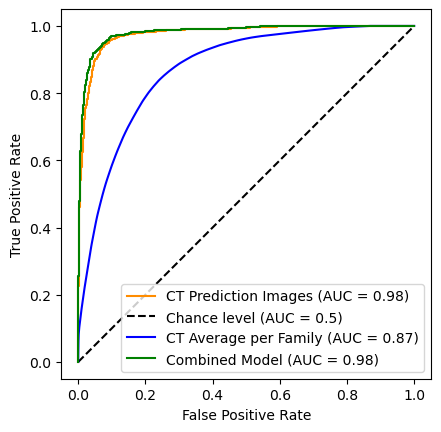

In [28]:
fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(
    train_labels,
    train_probs,
    name="CT Prediction Images",
    color="darkorange",
    plot_chance_level=True,
    ax=ax
)
RocCurveDisplay.from_predictions(
    train_labels[~np.isnan(train_mean)],
    train_mean[~np.isnan(train_mean)],
    name="CT Average per Family",
    color="blue",
    ax=ax,
)
RocCurveDisplay.from_predictions(
    train_labels[~np.isnan(train_mean)],
    # np.ones(preds_logistic.shape[0]),
    train_combined[:,1],
    # np.maximum( np.array(valid_data.labels).transpose(),np.transpose(valid_probs)),
    name="Combined Model",
    color="green",
    ax=ax
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("")
plt.legend()
plt.show()

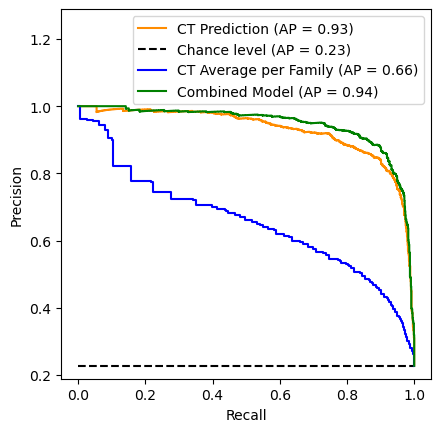

In [29]:
fig, ax = plt.subplots()
PrecisionRecallDisplay.from_predictions(
    train_labels,
    train_probs,
    name="CT Prediction",
    color="darkorange",
    plot_chance_level=True,
    ax=ax
)
PrecisionRecallDisplay.from_predictions(
    train_labels[~np.isnan(train_mean)],
    train_mean[~np.isnan(train_mean)],
    name="CT Average per Family",
    color="blue",
    ax=ax
)

PrecisionRecallDisplay.from_predictions(
    train_labels[~np.isnan(train_mean)],
    # np.ones(preds_logistic.shape[0]),
    train_combined[:,1],
    # np.maximum( np.array(valid_data.labels).transpose(),np.transpose(valid_probs)),
    name="Combined Model",
    color="green",
    ax=ax
)

plt.axis("square")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("")
plt.legend()
plt.show()

## Valid

In [30]:
valid_labels = np.concatenate(valid_labels)
valid_preds = np.concatenate(valid_preds)
valid_probs = np.concatenate(valid_probs)

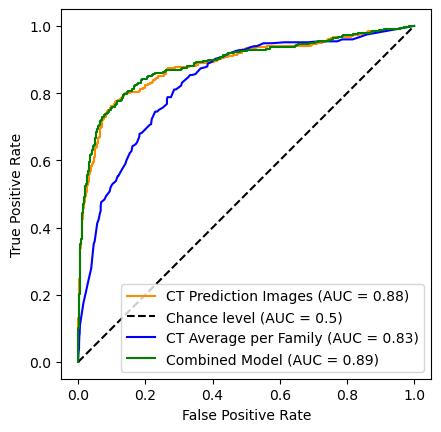

In [31]:
fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(
    valid_labels,
    valid_probs,
    name="CT Prediction Images",
    color="darkorange",
    plot_chance_level=True,
    ax=ax
)
RocCurveDisplay.from_predictions(
    valid_labels[~np.isnan(valid_mean)],
    valid_mean[~np.isnan(valid_mean)],
    name="CT Average per Family",
    color="blue",
    ax=ax,
)
RocCurveDisplay.from_predictions(
    valid_labels[~np.isnan(valid_mean)],
    # np.ones(preds_logistic.shape[0]),
    valid_combined[:,1],
    # np.maximum( np.array(valid_data.labels).transpose(),np.transpose(valid_probs)),
    name="Combined Model",
    color="green",
    ax=ax
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("")
plt.legend()
plt.show()

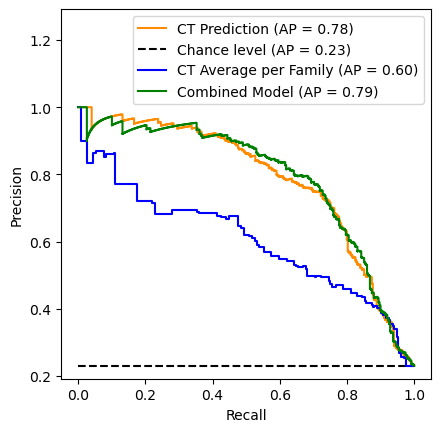

In [32]:
fig, ax = plt.subplots()
PrecisionRecallDisplay.from_predictions(
    valid_labels,
    valid_probs,
    name="CT Prediction",
    color="darkorange",
    plot_chance_level=True,
    ax=ax
)
PrecisionRecallDisplay.from_predictions(
    valid_labels[~np.isnan(valid_mean)],
    valid_mean[~np.isnan(valid_mean)],
    name="CT Average per Family",
    color="blue",
    ax=ax
)

PrecisionRecallDisplay.from_predictions(
    valid_labels[~np.isnan(valid_mean)],
    # np.ones(preds_logistic.shape[0]),
    valid_combined[:,1],
    # np.maximum( np.array(valid_data.labels).transpose(),np.transpose(valid_probs)),
    name="Combined Model",
    color="green",
    ax=ax
)

plt.axis("square")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("")
plt.legend()
plt.show()

# F1

Finally, the F1 score

In [33]:
train_preds = list()
train_labels = list()
train_probs = list()

valid_preds = list()
valid_labels = list()
valid_probs = list()

test_preds = list()
test_labels = list()
test_probs = list()

train_mean = list()
valid_mean = list()
test_mean = list()
    
train_combined = list()
valid_combined = list()
test_combined = list()


In [34]:
for ii in range(len(runs)):
    arts = runs[ii].logged_artifacts()
    arts_dict = {a.name.removesuffix(':'+a.version): a for a in arts}
    training_slides = arts_dict['fold'].get('training').get_dataframe()
    valid_slides = arts_dict['fold'].get('validation').get_dataframe()
    testing_slides = arts_dict['fold'].get('testing').get_dataframe()
    
    train_data = slide_annots.loc[training_slides[0]]
    valid_data = slide_annots.loc[valid_slides[0]]
    test_data = slide_annots.loc[testing_slides[0]]
    
    train_mean.append(pd.merge(train_data,train_data.groupby('family').labels.mean(), how='left', left_on='family',right_on='family').labels_y)
    valid_mean.append(pd.merge(valid_data,train_data.groupby('family').labels.mean(), how='left', left_on='family',right_on='family').labels_y)
    test_mean.append(pd.merge(test_data,train_data.groupby('family').labels.mean(), how='left', left_on='family',right_on='family').labels_y)
    
    train_labels.append(np.abs(1-train_data.CT_class.factorize(sort=True)[0]))
    train_preds.append(arts_dict['preds_f1'].get('training').get_dataframe())
    train_probs.append(arts_dict['preds_f1'].get('training_probs').get_dataframe())

    valid_labels.append(np.abs(1-valid_data.CT_class.factorize(sort=True)[0]))
    valid_preds.append(arts_dict['preds_f1'].get('validation').get_dataframe())
    valid_probs.append(arts_dict['preds_f1'].get('validation_probs').get_dataframe())
    
    test_labels.append(np.abs(1-test_data.CT_class.factorize(sort=True)[0]))
    test_preds.append(arts_dict['preds_f1'].get('testing').get_dataframe())
    test_probs.append(arts_dict['preds_f1'].get('testing_probs').get_dataframe())
    
    logistic_model= sklearn.linear_model.LogisticRegression(penalty=None)

    X_train = np.stack([np.transpose(train_probs[ii][0]), np.array(train_mean[ii]).transpose()])
    X_valid = np.stack([np.transpose(valid_probs[ii][0]), np.array(valid_mean[ii]).transpose()])
    X_test = np.stack([np.transpose(test_probs[ii][0]), np.array(test_mean[ii]).transpose()])
     
    
    logistic_model.fit(X_train.transpose()[~np.isnan(train_mean[ii])], train_labels[ii][~np.isnan(train_mean[ii])])
    train_combined.append(logistic_model.predict_proba(X_train.transpose()[~np.isnan(train_mean[ii])]))
    valid_combined.append(logistic_model.predict_proba(X_valid.transpose()[~np.isnan(valid_mean[ii])]))
    test_combined.append(logistic_model.predict_proba(X_test.transpose()[~np.isnan(test_mean[ii])]))


wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   3 of 3 files downlo

In [35]:
train_mean = np.concatenate(train_mean)
valid_mean = np.concatenate(valid_mean)
test_mean = np.concatenate(test_mean)


In [36]:
train_combined = np.concatenate(train_combined)
valid_combined = np.concatenate(valid_combined)
test_combined = np.concatenate(test_combined)

In [37]:
len(np.concatenate(valid_preds))

1515

In [38]:
len(np.concatenate(test_preds))

1503

In [39]:
train_labels = np.concatenate(train_labels)
train_preds = np.concatenate(train_preds)
train_probs = np.concatenate(train_probs)


In [40]:
train_combined

array([[9.12405367e-01, 8.75946335e-02],
       [9.47153454e-01, 5.28465458e-02],
       [9.94171512e-01, 5.82848796e-03],
       ...,
       [9.82777728e-01, 1.72222722e-02],
       [9.99999876e-01, 1.23688514e-07],
       [7.58319018e-05, 9.99924168e-01]])

## Train

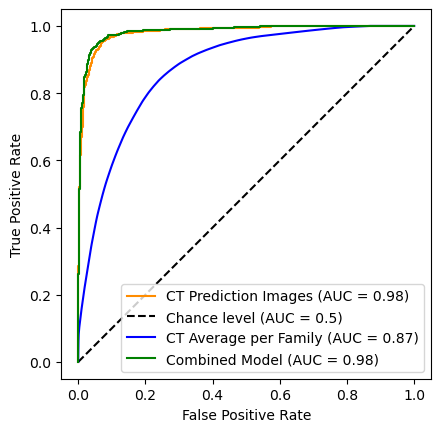

In [41]:
fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(
    train_labels,
    train_probs,
    name="CT Prediction Images",
    color="darkorange",
    plot_chance_level=True,
    ax=ax
)
RocCurveDisplay.from_predictions(
    train_labels[~np.isnan(train_mean)],
    train_mean[~np.isnan(train_mean)],
    name="CT Average per Family",
    color="blue",
    ax=ax,
)
RocCurveDisplay.from_predictions(
    train_labels[~np.isnan(train_mean)],
    # np.ones(preds_logistic.shape[0]),
    train_combined[:,1],
    # np.maximum( np.array(valid_data.labels).transpose(),np.transpose(valid_probs)),
    name="Combined Model",
    color="green",
    ax=ax
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("")
plt.legend()
plt.show()

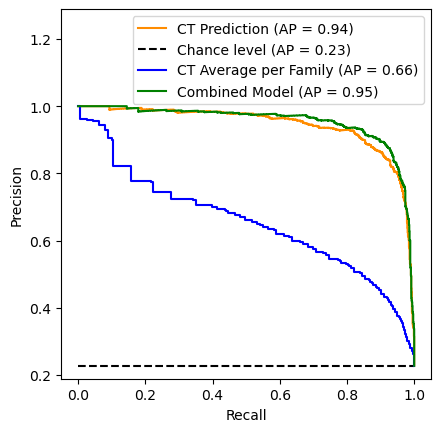

In [42]:
fig, ax = plt.subplots()
PrecisionRecallDisplay.from_predictions(
    train_labels,
    train_probs,
    name="CT Prediction",
    color="darkorange",
    plot_chance_level=True,
    ax=ax
)
PrecisionRecallDisplay.from_predictions(
    train_labels[~np.isnan(train_mean)],
    train_mean[~np.isnan(train_mean)],
    name="CT Average per Family",
    color="blue",
    ax=ax
)

PrecisionRecallDisplay.from_predictions(
    train_labels[~np.isnan(train_mean)],
    # np.ones(preds_logistic.shape[0]),
    train_combined[:,1],
    # np.maximum( np.array(valid_data.labels).transpose(),np.transpose(valid_probs)),
    name="Combined Model",
    color="green",
    ax=ax
)

plt.axis("square")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("")
plt.legend()
plt.show()

## Valid

In [43]:
valid_labels = np.concatenate(valid_labels)
valid_preds = np.concatenate(valid_preds)
valid_probs = np.concatenate(valid_probs)

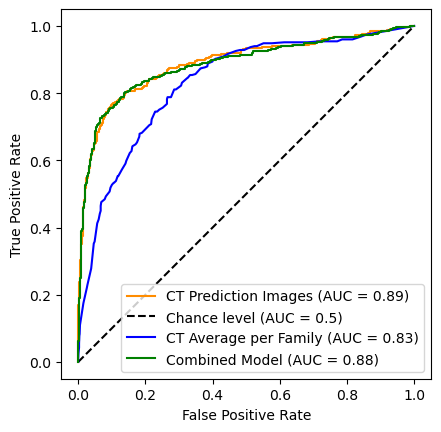

In [44]:
fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(
    valid_labels,
    valid_probs,
    name="CT Prediction Images",
    color="darkorange",
    plot_chance_level=True,
    ax=ax
)
RocCurveDisplay.from_predictions(
    valid_labels[~np.isnan(valid_mean)],
    valid_mean[~np.isnan(valid_mean)],
    name="CT Average per Family",
    color="blue",
    ax=ax,
)
RocCurveDisplay.from_predictions(
    valid_labels[~np.isnan(valid_mean)],
    # np.ones(preds_logistic.shape[0]),
    valid_combined[:,1],
    # np.maximum( np.array(valid_data.labels).transpose(),np.transpose(valid_probs)),
    name="Combined Model",
    color="green",
    ax=ax
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("")
plt.legend()
plt.show()

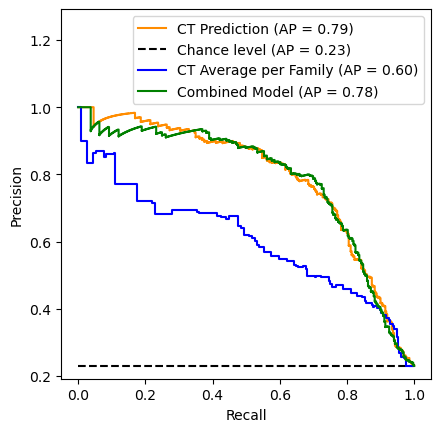

In [45]:
fig, ax = plt.subplots()
PrecisionRecallDisplay.from_predictions(
    valid_labels,
    valid_probs,
    name="CT Prediction",
    color="darkorange",
    plot_chance_level=True,
    ax=ax
)
PrecisionRecallDisplay.from_predictions(
    valid_labels[~np.isnan(valid_mean)],
    valid_mean[~np.isnan(valid_mean)],
    name="CT Average per Family",
    color="blue",
    ax=ax
)

PrecisionRecallDisplay.from_predictions(
    valid_labels[~np.isnan(valid_mean)],
    # np.ones(preds_logistic.shape[0]),
    valid_combined[:,1],
    # np.maximum( np.array(valid_data.labels).transpose(),np.transpose(valid_probs)),
    name="Combined Model",
    color="green",
    ax=ax
)

plt.axis("square")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("")
plt.legend()
plt.show()

# Summary

The results are as follows:

| Stopping Method | Score | Train | Valid| Difference| 
| --- | --- | --- |  --- |  --- | 
| Loss | AUROC | 95 | 92 | 3|
| Loss | AUPR | 89 | 84 | 5 |
| Error | AUROC | 96 | 90 | 6 |
| Error | AUPR | 90 | 82 | 8 |
| F1 | AUROC | 97 | 91 | 6 |
| F1 | AUPR | 91 | 83 | 8 |

Loss seems to perform best both numerically and by the gap, so we reload it and evaluate the testing performance

## Reload loss

In [46]:
train_preds = list()
train_labels = list()
train_probs = list()

valid_preds = list()
valid_labels = list()
valid_probs = list()

test_preds = list()
test_labels = list()
test_probs = list()

train_mean = list()
valid_mean = list()
test_mean = list()
    
train_combined = list()
valid_combined = list()
test_combined = list()


train_family = list()
valid_family = list()
test_family = list()


train_superfamily = list()
valid_superfamily = list()
test_superfamily = list()


In [47]:
for ii in range(len(runs)):
    arts = runs[ii].logged_artifacts()
    arts_dict = {a.name.removesuffix(':'+a.version): a for a in arts}
    training_slides = arts_dict['fold'].get('training').get_dataframe()
    valid_slides = arts_dict['fold'].get('validation').get_dataframe()
    testing_slides = arts_dict['fold'].get('testing').get_dataframe()
    
    train_data = slide_annots.loc[training_slides[0]]
    valid_data = slide_annots.loc[valid_slides[0]]
    test_data = slide_annots.loc[testing_slides[0]]
    
    train_family.append(np.array(train_data.family))
    valid_family.append(np.array(valid_data.family))
    test_family.append(np.array(test_data.family))
    
    train_superfamily.append(np.array(train_data.max_super_family_class))
    valid_superfamily.append(np.array(valid_data.max_super_family_class))
    test_superfamily.append(np.array(test_data.max_super_family_class))
    
    train_mean.append(pd.merge(train_data,train_data.groupby('family').labels.mean(), how='left', left_on='family',right_on='family').labels_y)
    valid_mean.append(pd.merge(valid_data,train_data.groupby('family').labels.mean(), how='left', left_on='family',right_on='family').labels_y)
    test_mean.append(pd.merge(test_data,train_data.groupby('family').labels.mean(), how='left', left_on='family',right_on='family').labels_y)
    
    train_labels.append(np.abs(1-train_data.CT_class.factorize(sort=True)[0]))
    train_preds.append(arts_dict['preds_loss'].get('training').get_dataframe())
    train_probs.append(arts_dict['preds_loss'].get('training_probs').get_dataframe())

    valid_labels.append(np.abs(1-valid_data.CT_class.factorize(sort=True)[0]))
    valid_preds.append(arts_dict['preds_loss'].get('validation').get_dataframe())
    valid_probs.append(arts_dict['preds_loss'].get('validation_probs').get_dataframe())
    
    test_labels.append(np.abs(1-test_data.CT_class.factorize(sort=True)[0]))
    test_preds.append(arts_dict['preds_loss'].get('testing').get_dataframe())
    test_probs.append(arts_dict['preds_loss'].get('testing_probs').get_dataframe())
    
    logistic_model= sklearn.linear_model.LogisticRegression(penalty=None)

    X_train = np.stack([np.transpose(train_probs[ii][0]), np.array(train_mean[ii]).transpose()])
    X_valid = np.stack([np.transpose(valid_probs[ii][0]), np.array(valid_mean[ii]).transpose()])
    X_test = np.stack([np.transpose(test_probs[ii][0]), np.array(test_mean[ii]).transpose()])
     
    
    logistic_model.fit(X_train.transpose()[~np.isnan(train_mean[ii])], train_labels[ii][~np.isnan(train_mean[ii])])
    train_combined.append(logistic_model.predict_proba(X_train.transpose()[~np.isnan(train_mean[ii])]))
    valid_combined.append(logistic_model.predict_proba(X_valid.transpose()[~np.isnan(valid_mean[ii])]))
    test_combined.append(logistic_model.predict_proba(X_test.transpose()[~np.isnan(test_mean[ii])]))


wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   3 of 3 files downlo

In [48]:
train_family = np.concatenate(train_family)
valid_family = np.concatenate(valid_family)
test_family = np.concatenate(test_family)


In [49]:
train_superfamily = np.concatenate(train_superfamily)
valid_superfamily = np.concatenate(valid_superfamily)
test_superfamily = np.concatenate(test_superfamily)


In [50]:
train_mean = np.concatenate(train_mean)
valid_mean = np.concatenate(valid_mean)
test_mean = np.concatenate(test_mean)


In [51]:
train_combined = np.concatenate(train_combined)
valid_combined = np.concatenate(valid_combined)
test_combined = np.concatenate(test_combined)

In [52]:
test_labels = np.concatenate(test_labels)
test_preds = np.concatenate(test_preds)
test_probs = np.concatenate(test_probs)


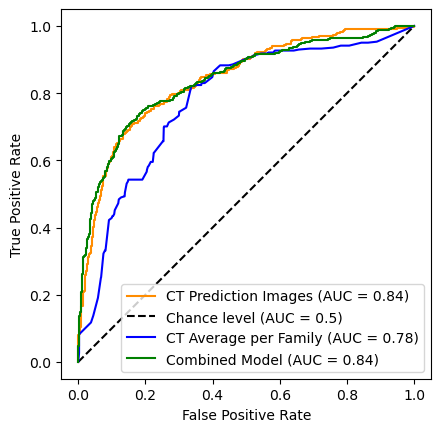

In [53]:
fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(
    test_labels,
    test_probs,
    name="CT Prediction Images",
    color="darkorange",
    plot_chance_level=True,
    ax=ax
)
RocCurveDisplay.from_predictions(
    test_labels[~np.isnan(test_mean)],
    test_mean[~np.isnan(test_mean)],
    name="CT Average per Family",
    color="blue",
    ax=ax,
)
RocCurveDisplay.from_predictions(
    test_labels[~np.isnan(test_mean)],
    # np.ones(preds_logistic.shape[0]),
    test_combined[:,1],
    # np.maximum( np.array(valid_data.labels).transpose(),np.transpose(valid_probs)),
    name="Combined Model",
    color="green",
    ax=ax
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("")
plt.legend()
plt.show()

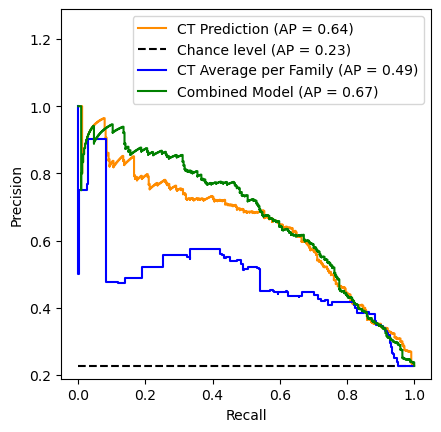

In [54]:
fig, ax = plt.subplots()
PrecisionRecallDisplay.from_predictions(
    test_labels,
    test_probs,
    name="CT Prediction",
    color="darkorange",
    plot_chance_level=True,
    ax=ax
)
PrecisionRecallDisplay.from_predictions(
    test_labels[~np.isnan(test_mean)],
    test_mean[~np.isnan(test_mean)],
    name="CT Average per Family",
    color="blue",
    ax=ax
)

PrecisionRecallDisplay.from_predictions(
    test_labels[~np.isnan(test_mean)],
    # np.ones(preds_logistic.shape[0]),
    test_combined[:,1],
    # np.maximum( np.array(valid_data.labels).transpose(),np.transpose(valid_probs)),
    name="Combined Model",
    color="green",
    ax=ax
)

plt.axis("square")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("")
plt.legend()
plt.show()

# Lets look into subgroup analysis

In [55]:
pd.Series(test_superfamily).value_counts()

Ependymal tumours                                            223
Adult-type diffuse gliomas                                   215
Low-grade glial/glioneuronal/neuroepithelial tumours         196
tumours of the sellar region                                 134
Medulloblastoma                                               93
Cranial and paraspinal nerve tumours                          88
Control tissues                                               81
Mesenchymal, non-meningothelial tumours involving the CNS     72
Other CNS embryonal tumours                                   63
meningioma                                                    61
Paediatric-type diffuse high-grade gliomas                    60
diffuse glioma, MAPK altered, cell-cycle activated            29
Pineal parenchymal and retinal tumours                        27
choroid plexus tumours                                        24
Circumscribed astrocytic tumours                              22
Germ cell tumours        

In [56]:
show(pd.DataFrame(slide_annots.loc[slide_annots.CT_class != "Unsure"].groupby('max_super_family_class').CT_class.value_counts()))

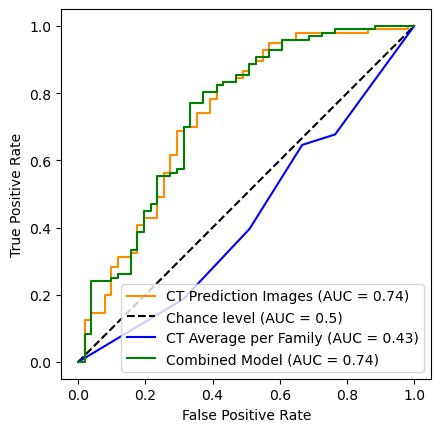

In [57]:
glioblasoma_indices = test_family=="glioblastoma"


fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(
    test_labels[glioblasoma_indices],
    test_probs[glioblasoma_indices],
    name="CT Prediction Images",
    color="darkorange",
    plot_chance_level=True,
    ax=ax
)
RocCurveDisplay.from_predictions(
    test_labels[glioblasoma_indices][~np.isnan(test_mean)[glioblasoma_indices]],
    test_mean[glioblasoma_indices][~np.isnan(test_mean)[glioblasoma_indices]],
    name="CT Average per Family",
    color="blue",
    ax=ax,
)
RocCurveDisplay.from_predictions(
    test_labels[glioblasoma_indices][~np.isnan(test_mean)[glioblasoma_indices]],
    # np.ones(preds_logistic.shape[0]),
    test_combined[glioblasoma_indices[~np.isnan(test_mean)],1],
    # np.maximum( np.array(valid_data.labels).transpose(),np.transpose(valid_probs)),
    name="Combined Model",
    color="green",
    ax=ax
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("")
plt.legend()
plt.show()

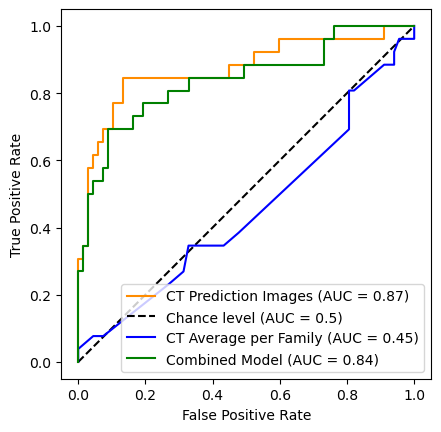

In [58]:
medullo_indicies = test_superfamily == 'Medulloblastoma'


fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(
    test_labels[medullo_indicies],
    test_probs[medullo_indicies],
    name="CT Prediction Images",
    color="darkorange",
    plot_chance_level=True,
    ax=ax
)
RocCurveDisplay.from_predictions(
    test_labels[medullo_indicies][~np.isnan(test_mean)[medullo_indicies]],
    test_mean[medullo_indicies][~np.isnan(test_mean)[medullo_indicies]],
    name="CT Average per Family",
    color="blue",
    ax=ax,
)
RocCurveDisplay.from_predictions(
    test_labels[medullo_indicies][~np.isnan(test_mean)[medullo_indicies]],
    # np.ones(preds_logistic.shape[0]),
    test_combined[medullo_indicies[~np.isnan(test_mean)],1],
    # np.maximum( np.array(valid_data.labels).transpose(),np.transpose(valid_probs)),
    name="Combined Model",
    color="green",
    ax=ax
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("")
plt.legend()
plt.show()

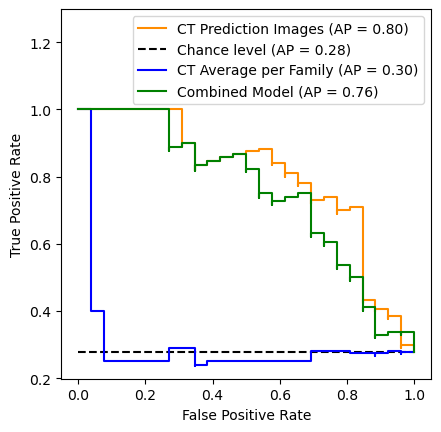

In [59]:

fig, ax = plt.subplots()
PrecisionRecallDisplay.from_predictions(
    test_labels[medullo_indicies],
    test_probs[medullo_indicies],
    name="CT Prediction Images",
    color="darkorange",
    plot_chance_level=True,
    ax=ax
)
PrecisionRecallDisplay.from_predictions(
    test_labels[medullo_indicies][~np.isnan(test_mean)[medullo_indicies]],
    test_mean[medullo_indicies][~np.isnan(test_mean)[medullo_indicies]],
    name="CT Average per Family",
    color="blue",
    ax=ax,
)
PrecisionRecallDisplay.from_predictions(
    test_labels[medullo_indicies][~np.isnan(test_mean)[medullo_indicies]],
    # np.ones(preds_logistic.shape[0]),
    test_combined[medullo_indicies[~np.isnan(test_mean)],1],
    # np.maximum( np.array(valid_data.labels).transpose(),np.transpose(valid_probs)),
    name="Combined Model",
    color="green",
    ax=ax
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("")
plt.legend()
plt.show()

In [60]:
medullo_indicies.sum()

93

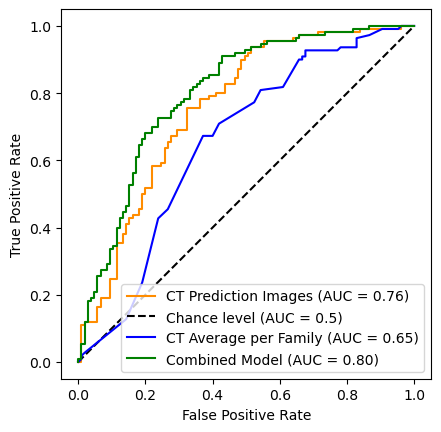

In [61]:
difglioma_indicies = test_superfamily == 'Adult-type diffuse gliomas'


fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(
    test_labels[difglioma_indicies],
    test_probs[difglioma_indicies],
    name="CT Prediction Images",
    color="darkorange",
    plot_chance_level=True,
    ax=ax
)
RocCurveDisplay.from_predictions(
    test_labels[difglioma_indicies][~np.isnan(test_mean)[difglioma_indicies]],
    test_mean[difglioma_indicies][~np.isnan(test_mean)[difglioma_indicies]],
    name="CT Average per Family",
    color="blue",
    ax=ax,
)
RocCurveDisplay.from_predictions(
    test_labels[difglioma_indicies][~np.isnan(test_mean)[difglioma_indicies]],
    # np.ones(preds_logistic.shape[0]),
    test_combined[difglioma_indicies[~np.isnan(test_mean)],1],
    # np.maximum( np.array(valid_data.labels).transpose(),np.transpose(valid_probs)),
    name="Combined Model",
    color="green",
    ax=ax
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("")
plt.legend()
plt.show()

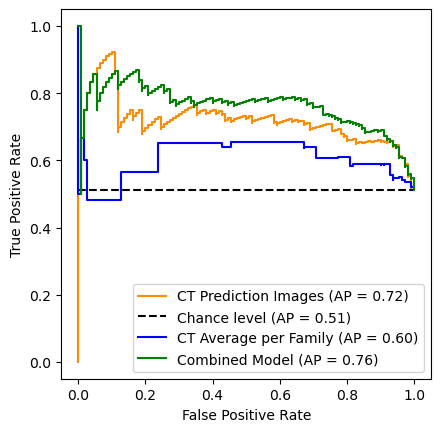

In [62]:

fig, ax = plt.subplots()
PrecisionRecallDisplay.from_predictions(
    test_labels[difglioma_indicies],
    test_probs[difglioma_indicies],
    name="CT Prediction Images",
    color="darkorange",
    plot_chance_level=True,
    ax=ax
)
PrecisionRecallDisplay.from_predictions(
    test_labels[difglioma_indicies][~np.isnan(test_mean)[difglioma_indicies]],
    test_mean[difglioma_indicies][~np.isnan(test_mean)[difglioma_indicies]],
    name="CT Average per Family",
    color="blue",
    ax=ax,
)
PrecisionRecallDisplay.from_predictions(
    test_labels[difglioma_indicies][~np.isnan(test_mean)[difglioma_indicies]],
    # np.ones(preds_logistic.shape[0]),
    test_combined[difglioma_indicies[~np.isnan(test_mean)],1],
    # np.maximum( np.array(valid_data.labels).transpose(),np.transpose(valid_probs)),
    name="Combined Model",
    color="green",
    ax=ax
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("")
plt.legend()
plt.show()

In [63]:
difglioma_indicies.sum()

215

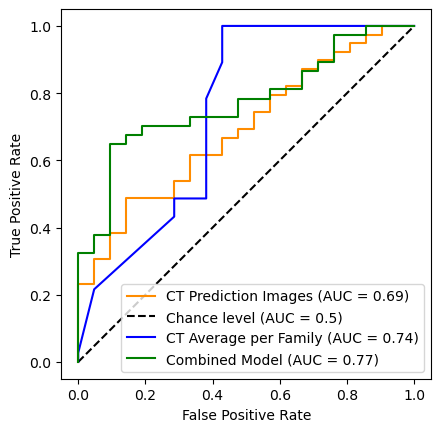

In [64]:
peddifglioma_indicies = test_superfamily == "Paediatric-type diffuse high-grade gliomas"


fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(
    test_labels[peddifglioma_indicies],
    test_probs[peddifglioma_indicies],
    name="CT Prediction Images",
    color="darkorange",
    plot_chance_level=True,
    ax=ax
)
RocCurveDisplay.from_predictions(
    test_labels[peddifglioma_indicies][~np.isnan(test_mean)[peddifglioma_indicies]],
    test_mean[peddifglioma_indicies][~np.isnan(test_mean)[peddifglioma_indicies]],
    name="CT Average per Family",
    color="blue",
    ax=ax,
)
RocCurveDisplay.from_predictions(
    test_labels[peddifglioma_indicies][~np.isnan(test_mean)[peddifglioma_indicies]],
    # np.ones(preds_logistic.shape[0]),
    test_combined[peddifglioma_indicies[~np.isnan(test_mean)],1],
    # np.maximum( np.array(valid_data.labels).transpose(),np.transpose(valid_probs)),
    name="Combined Model",
    color="green",
    ax=ax
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("")
plt.legend()
plt.show()

In [65]:
peddifglioma_indicies.sum()


60

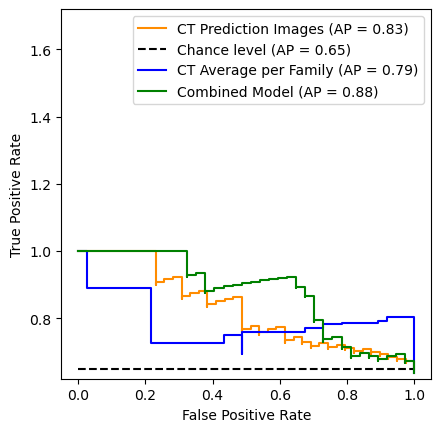

In [66]:

fig, ax = plt.subplots()
PrecisionRecallDisplay.from_predictions(
    test_labels[peddifglioma_indicies],
    test_probs[peddifglioma_indicies],
    name="CT Prediction Images",
    color="darkorange",
    plot_chance_level=True,
    ax=ax
)
PrecisionRecallDisplay.from_predictions(
    test_labels[peddifglioma_indicies][~np.isnan(test_mean)[peddifglioma_indicies]],
    test_mean[peddifglioma_indicies][~np.isnan(test_mean)[peddifglioma_indicies]],
    name="CT Average per Family",
    color="blue",
    ax=ax,
)
PrecisionRecallDisplay.from_predictions(
    test_labels[peddifglioma_indicies][~np.isnan(test_mean)[peddifglioma_indicies]],
    # np.ones(preds_logistic.shape[0]),
    test_combined[peddifglioma_indicies[~np.isnan(test_mean)],1],
    # np.maximum( np.array(valid_data.labels).transpose(),np.transpose(valid_probs)),
    name="Combined Model",
    color="green",
    ax=ax
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("")
plt.legend()
plt.show()

In [67]:
len(test_labels)

1503

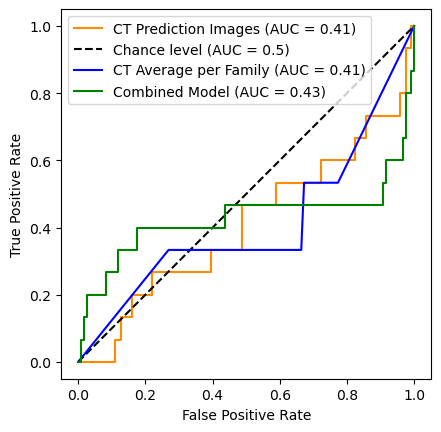

In [68]:
sellar_indicies = test_superfamily == "tumours of the sellar region"


fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(
    test_labels[sellar_indicies],
    test_probs[sellar_indicies],
    name="CT Prediction Images",
    color="darkorange",
    plot_chance_level=True,
    ax=ax
)
RocCurveDisplay.from_predictions(
    test_labels[sellar_indicies][~np.isnan(test_mean)[sellar_indicies]],
    test_mean[sellar_indicies][~np.isnan(test_mean)[sellar_indicies]],
    name="CT Average per Family",
    color="blue",
    ax=ax,
)
RocCurveDisplay.from_predictions(
    test_labels[sellar_indicies][~np.isnan(test_mean)[sellar_indicies]],
    # np.ones(preds_logistic.shape[0]),
    test_combined[sellar_indicies[~np.isnan(test_mean)],1],
    # np.maximum( np.array(valid_data.labels).transpose(),np.transpose(valid_probs)),
    name="Combined Model",
    color="green",
    ax=ax
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("")
plt.legend()
plt.show()

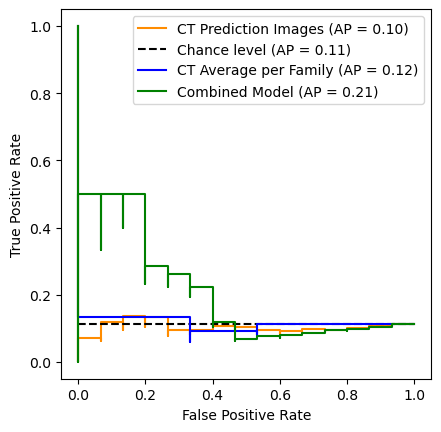

In [69]:

fig, ax = plt.subplots()
PrecisionRecallDisplay.from_predictions(
    test_labels[sellar_indicies],
    test_probs[sellar_indicies],
    name="CT Prediction Images",
    color="darkorange",
    plot_chance_level=True,
    ax=ax
)
PrecisionRecallDisplay.from_predictions(
    test_labels[sellar_indicies][~np.isnan(test_mean)[sellar_indicies]],
    test_mean[sellar_indicies][~np.isnan(test_mean)[sellar_indicies]],
    name="CT Average per Family",
    color="blue",
    ax=ax,
)
PrecisionRecallDisplay.from_predictions(
    test_labels[sellar_indicies][~np.isnan(test_mean)[sellar_indicies]],
    # np.ones(preds_logistic.shape[0]),
    test_combined[sellar_indicies[~np.isnan(test_mean)],1],
    # np.maximum( np.array(valid_data.labels).transpose(),np.transpose(valid_probs)),
    name="Combined Model",
    color="green",
    ax=ax
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("")
plt.legend()
plt.show()

In [70]:
sellar_indicies.sum()

134

In [71]:
slide_annots[slide_annots.CT_class != "Unsure"]

,uuid,tumor_id,txt_LOKALISATION,num_ALTERSANGABE,patient_id,max_super_family_class,max_family_class,max_class,max_subclass,relevant Histo prediction,...,classifciation_v11,max_cal_v11,family,file_path,slide,Unnamed: 0,idat,CT_class,file,labels
uuid,,,,,,,,,,,,,,,,,,,,,
1EE2D6AD-2F2A-4457-BA86-4CC8D137249D,1EE2D6AD-2F2A-4457-BA86-4CC8D137249D,73896,"infratentoriell, sakral",30.0,4981,Ependymal tumours,myxopapillary ependymoma,myxopapillary ependymoma,Myxopapillary ependymoma,Myxopapillary ependymoma,...,"methylation class ependymoma, myxopapillary",0.996477,ependymoma,/omics/odcf/analysis/OE0606_projects/pancancer...,1EE2D6AD-2F2A-4457-BA86-4CC8D137249D,41.0,10003886253_R02C02,Chromothripsis,1EE2D6AD-2F2A-4457-BA86-4CC8D137249D.h5,1
9625ECC7-5AA1-4ADF-B99E-B2F959A2317E,9625ECC7-5AA1-4ADF-B99E-B2F959A2317E,73878,"spinal, TH 11/12 extramedullär",71.0,5395,"Mesenchymal, non-meningothelial tumours involv...",Fibroblastic and myofibroblastic tumours,solitary fibrous tumour / haemangiopericytoma,Solitary fibrous tumour / haemangiopericytoma,Solitary fibrous tumour / haemangiopericytoma,...,methylation class solitary fibrous tumor / hem...,0.999968,hemangiopericytoma,/omics/odcf/analysis/OE0606_projects/pancancer...,9625ECC7-5AA1-4ADF-B99E-B2F959A2317E,42.0,10003886253_R03C01,No Chromothripsis,9625ECC7-5AA1-4ADF-B99E-B2F959A2317E.h5,0
A0517565-0BA3-43F8-A54C-33F403262927,A0517565-0BA3-43F8-A54C-33F403262927,73948,infratentoriell,34.0,5460,Control tissues,"control tissue, reactive tumour microenvironment","control tissue, reactive tumour microenvironment","Control tissue, reactive tumour microenvironment","Control tissue, reactive tumour microenvironment",...,"methylation class low grade glioma, subclass p...",0.149055,PA and other MAPK LGGNT,/omics/odcf/analysis/OE0606_projects/pancancer...,A0517565-0BA3-43F8-A54C-33F403262927,55.0,10003886256_R03C02,No Chromothripsis,A0517565-0BA3-43F8-A54C-33F403262927.h5,0
BCEBE5E3-E482-4E27-82FD-A2FFF12F5C84,BCEBE5E3-E482-4E27-82FD-A2FFF12F5C84,74034,"infratentoriell, hintere Schädelgrube",14.0,5457,Medulloblastoma,"medulloblastoma, WNT activated","medulloblastoma, WNT activated","Medulloblastoma, WNT activated","Medulloblastoma, WNT activated",...,"methylation class medulloblastoma, WNT",0.999083,medulloblastoma_WNT,/omics/odcf/analysis/OE0606_projects/pancancer...,BCEBE5E3-E482-4E27-82FD-A2FFF12F5C84,64.0,10003886258_R02C01,No Chromothripsis,BCEBE5E3-E482-4E27-82FD-A2FFF12F5C84.h5,0
88FB4DE0-39AE-4FD6-ACFA-68C35A57669F,88FB4DE0-39AE-4FD6-ACFA-68C35A57669F,74022,"supratentoriell, frontal rechts",11.0,5459,Low-grade glial/glioneuronal/neuroepithelial t...,low-grade glioneuronal tumour,dysembryoplastic neuroepithelial tumour,Dysembryoplastic neuroepithelial tumour,Dysembryoplastic neuroepithelial tumour,...,"methylation class low grade glioma, dysembryop...",0.999950,PA and other MAPK LGGNT,NaN,88FB4DE0-39AE-4FD6-ACFA-68C35A57669F,76.0,10003886259_R02C01,No Chromothripsis,88FB4DE0-39AE-4FD6-ACFA-68C35A57669F.h5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24D39BD4-471B-43E7-A23D-1647F9DD9F54,24D39BD4-471B-43E7-A23D-1647F9DD9F54,67402,NaN,21.0,2039,meningioma,meningioma,"meningioma, benign","Meningioma, subclass benign 1","meningioma, benign",...,methylation class meningioma,0.999110,meningioma,/omics/odcf/analysis/OE0606_projects/pancancer...,24D39BD4-471B-43E7-A23D-1647F9DD9F54,124466.0,9969477124_R05C02,No Chromothripsis,24D39BD4-471B-43E7-A23D-1647F9DD9F54.h5,0
95C1EFE3-112A-48EF-A15C-F7A39AC13247,95C1EFE3-112A-48EF-A15C-F7A39AC13247,71960,"supratentoriell, frontal",9.0,4583,Paediatric-type diffuse high-grade gliomas,"Diffuse pediatric-type high-grade glioma, H3-w...","Diffuse paediatric-type high grade glioma, RTK...","Diffuse paediatric-type high grade glioma, RTK...","Diffuse paediatric-type high grade glioma, RTK...",...,"methylation class low grade glioma, subclass h...",0.427709,PA and other MAPK LGGNT,/omics/odcf/analysis/OE0606_projects/pancan